In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline
torch.manual_seed(1)

In [2]:
def findFiles(path): return glob.glob(path)
print(os.getcwd())
print(findFiles('charRnn_data/names/*.txt'))

/media/gaurav/New Volume/Learning/ArtificialIntelligence/recurrent_nn
['charRnn_data/names/Arabic.txt', 'charRnn_data/names/Chinese.txt', 'charRnn_data/names/Czech.txt', 'charRnn_data/names/Dutch.txt', 'charRnn_data/names/English.txt', 'charRnn_data/names/French.txt', 'charRnn_data/names/German.txt', 'charRnn_data/names/Greek.txt', 'charRnn_data/names/Irish.txt', 'charRnn_data/names/Italian.txt', 'charRnn_data/names/Japanese.txt', 'charRnn_data/names/Korean.txt', 'charRnn_data/names/Polish.txt', 'charRnn_data/names/Portuguese.txt', 'charRnn_data/names/Russian.txt', 'charRnn_data/names/Scottish.txt', 'charRnn_data/names/Spanish.txt', 'charRnn_data/names/Vietnamese.txt']


In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [8]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

def readLines(file):
    f = open(file,'r')
    names = f.readlines()
    f.close()
    return list(map(lambda x: x.strip(),names))

for file in findFiles('charRnn_data/names/*.txt'):
    language = file.split('/')[-1].split('.')[0]
    category_lines[language] = readLines(file)
    all_categories.append(language)
    
n_categories = len(all_categories)

In [4]:
# Turn a word(name) to a Tensor such that each letter is represented as a one-hot vector
def one_hot_encoded_tensor(name):
    letter_tensor = torch.zeros([len(name),1,n_letters])
    indices = []
    for i,c in enumerate(name):
        idx = all_letters.find(c)
        # is there a better way to create a one-hot encoded vector?
        letter_tensor[i][0][idx] = 1
    return letter_tensor

In [5]:
class CharRNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,inp,hidden):
        combined = torch.cat((inp,hidden),1)
        hidden_out = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden_out
        
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [9]:
# create the training set as (Name,Language) and shuffle
# This approach will not work if there are duplicate names across different languages
from random import shuffle
def prepareTrainingData(categories):
    inv_categories = [(n,lang) for lang,names in categories.items() for n in names]
    shuffle(inv_categories)
    return inv_categories

training_data = prepareTrainingData(category_lines)

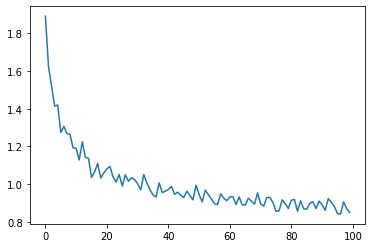

In [10]:
# Do the training
calc_avg_interval = 1000
categories_idx = {lang:i for i,lang in enumerate(all_categories)}
lossFunc = nn.NLLLoss()
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, n_categories)
optimizer = optim.SGD(rnn.parameters(),lr=0.001,momentum=0.9)
epochs, loop_count = 5, 0
losses, total_loss = [], 0
train_predictions = []
for _ in range(epochs):
    for sample in training_data:
        loop_count += 1
        hidden_inp = rnn.initHidden()

        optimizer.zero_grad()
        sample_encoded = one_hot_encoded_tensor(sample[0])
        for c in sample_encoded:
            output,hidden_inp = rnn(c,hidden_inp)

        max_i = torch.argmax(output)
        train_predictions.append([sample[0],sample[1],all_categories[max_i.item()]])
        loss = lossFunc(output,torch.tensor([categories_idx[sample[1]]]))
        loss.backward()
        optimizer.step()
        
        if loop_count%calc_avg_interval == 0:
            losses.append(total_loss/calc_avg_interval)
            total_loss = 0
        else:
            total_loss += loss
plt.plot(losses)
plt.show()

In [105]:
print(train_predictions[-100:])

[['Nurkaev', 'Russian', 'Russian'], ['Belik', 'Russian', 'Russian'], ['Finagin', 'Russian', 'Russian'], ['Lodge', 'English', 'English'], ['Woods', 'English', 'English'], ['Piontek', 'Polish', 'Czech'], ['Corti', 'Italian', 'Italian'], ['Kachemaev', 'Russian', 'Russian'], ['Kachurin', 'Russian', 'Russian'], ['Mahanov', 'Russian', 'Russian'], ['Dubrowsky', 'Russian', 'Russian'], ['Kahaya', 'Japanese', 'Japanese'], ['Groizman', 'Russian', 'Russian'], ['Jarrett', 'English', 'English'], ['Rosa', 'Spanish', 'Italian'], ['Tighearnach', 'Irish', 'Russian'], ['Imoo', 'Japanese', 'Japanese'], ['Pats', 'Russian', 'English'], ['Lock', 'English', 'English'], ['Filipek', 'Polish', 'Czech'], ['Metz', 'German', 'German'], ['Qureshi', 'Arabic', 'Arabic'], ['Anosov', 'Russian', 'Russian'], ['Agapeev', 'Russian', 'Russian'], ['Mingo', 'Spanish', 'Russian'], ['Zinkovsky', 'Russian', 'Russian'], ['Pochupailov', 'Russian', 'Russian'], ['Yamabe', 'Japanese', 'English'], ['Durnovtsev', 'Russian', 'Russian'], 